## Imports

In [95]:
# To embed plots in the notebooks
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np # numpy library
import scipy.linalg as lng # linear algebra from scipy library
from sklearn import preprocessing as preproc # load preprocessing function

# seaborn can be used to "prettify" default matplotlib plots by importing and setting as default
import seaborn as sns
sns.set() # Set searborn as default

## Load dataset

In [96]:
prostatePath = "Prostate.txt"

T = np.loadtxt(
    prostatePath, delimiter=" ", skiprows=1, usecols=[1, 2, 3, 4, 5, 6, 7, 8, 9]
)

y = T[:, 0]
X = T[:, 1:]

[n, p] = np.shape(X)

# Our chosen normalization centers and normalize the variables of a data matrix to unit length.
# We can use sklearn "Normalizer" to do this, but we must transpose the matrices to act on the variables instead of samples
X_pre = X - np.mean(X, axis=0)
y_pre = y - np.mean(y, axis=0)

normalizer = preproc.Normalizer().fit(X_pre.T)
X_pre = normalizer.transform(X_pre.T).T

## 1 Perform model selection for ridge regression (for the prostate data set):
> (a) Consider using ridge-regression solutions for the prostate data set. What is a suitable range for the shrinkage parameter $λ$ in which to search for an optimal solution in?

In [97]:
def ridgeMulti(X, _lambda, p, y):
    """Ridge implementation from last week"""
    I = np.eye(p)
    betas = np.linalg.inv(X.T @ X + _lambda * I) @ X.T @ y  # (8x97 * 97x8 + 1*8x8)
    return betas

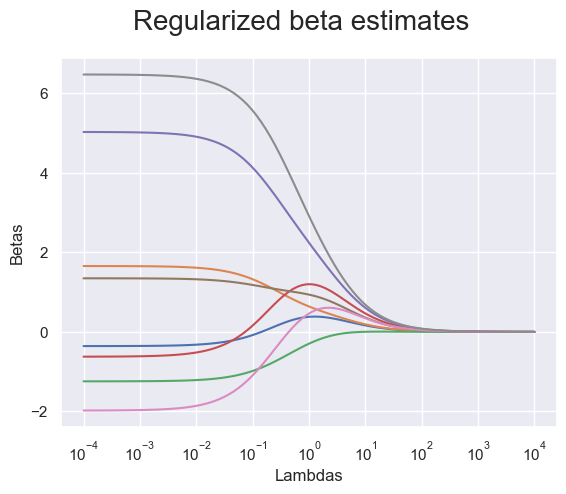

In [ ]:
k = 100
# try k values of lambda


lambdas = np.logspace(-4, 4, k)


betas = np.zeros((p, k))

for i, l in enumerate(lambdas):
    betas[:, i] = ridgeMulti(X_pre, l, p, y_pre)



plt.figure()


plt.semilogx(lambdas, betas.T)


plt.xlabel("Lambdas")


plt.ylabel("Betas")



plt.suptitle("Regularized beta estimates", fontsize=20)


plt.show()

What is a suitable range for $λ$ in which to search for an optimal solution?

A suitable range for $\lambda$ is $10^{-1}$ to $10^0$.


> (b) Select a suitable value for the regularization parameter using K-fold cross-validation. Plot the resulting optimal value of lambda on a plot of the parameter trace (i.e. a plot of the $\hat{β}_j$s as a function of $λ$).

>> (i) Try one of the common choices K = 5 and K = 10, and run the cross- validation a couple of times. Which would you prefer and why?
*Hint: To do Crossvalidation create a vector of length n that contains equal amounts of numbers from 1 to K and permute that vector.*

In [99]:
def centerData(data):

    mu = np.mean(data, axis=0)
    data = data - mu

    return data, mu

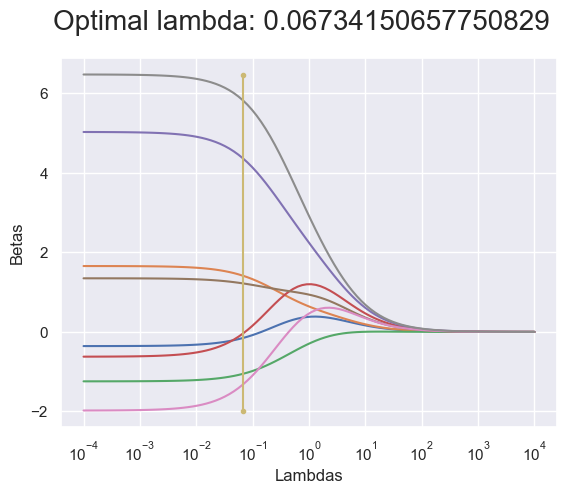

In [100]:
K = 10
lambdas = np.logspace(-4, 4, k)
MSE = np.zeros((10, 100))

# Create a vector of length n that contains equal amounts of numbers from 1 to K
vec = np.asarray([0] * n)
for i in range(n):
    vec[i] = (i) % K + 1

# Permute that vector.
np.random.shuffle(vec)


# For each chunk of data; run ridge for each lambda and calculate mean squared error
for i in range(1, K + 1):
    X_train, muX = centerData(X_pre[vec != i, :])
    y_train, muY = centerData(y_pre[vec != i])
    X_test = X_pre[vec == i, :] - muX
    y_test = y_pre[vec == i] - muY

    for j, l in enumerate(lambdas):
        beta = ridgeMulti(X_train, l, p, y_train)
        y_hat = X_test @ beta
        MSE[i - 1, j] = np.mean((y_hat - y_test) ** 2)
# average the mean squared error across chunks for the same lambda values to find the optimal lambda
mean_MSE = np.mean(MSE, axis=0)
lambda_OP = lambdas[np.argmin(mean_MSE)]

# Remember excact solution depends on a random indexing, so results may vary
# I reuse the plot with all the betas from 1 a) and add a line for the optimal value of lambda
plt.figure()
plt.semilogx(lambdas, betas.T)
plt.xlabel("Lambdas")
plt.ylabel("Betas")
plt.suptitle(f"Optimal lambda: {lambda_OP}", fontsize=20)
plt.semilogx([lambda_OP, lambda_OP], [np.min(betas), np.max(betas)], marker=".")
plt.show()

Where should you normalize your data?

We should normalize for each fold. 

(ii) What is the value of K corresponding to leave-one-out cross-validation?

$k=100$ or 97 depends how you define the vector

> (c) Find a suitable value of $λ$ using the one-standard-error rule. What is the difference between the two strategies (cross-validation and cross-validation with one- standard-error-rule)?

In [101]:
# Calculate the standard error for the best lambda, and find a the largest lambda with a MSE that is within
# the range of the optimal lambda +- the standard error.

seMSE = 1 / np.sqrt(K) * np.std(MSE, axis=0)
J = np.where(mean_MSE[np.argmin(mean_MSE)] + seMSE[np.argmin(mean_MSE)] > mean_MSE)[0]
j = int(J[-1])  # Because is the last one that fits the criteria
Lambda_CV_1StdRule = lambdas[j]
print("CV lambda with 1-std-rule %0.2f" % Lambda_CV_1StdRule)

CV lambda with 1-std-rule 0.43


> (d) Select suitable values for the regularization parameter using the AIC and BIC criteria (cf. 7.5-7.7 in ESL). What are the advantages and disadvantages of using cross-validation vs. information criteria?

In [109]:
D = np.zeros(100)
AIC = np.zeros(100)
BIC = np.zeros(100)

# Linear solver
beta_ols, _, rnk, s = lng.lstsq(X_pre, y_pre)
sigma2 = np.mean((y_pre - X_pre @ beta_ols) ** 2)
# calculate the AIC and BIC for ridge regression for different lambdas
# pick the lambda based on the models with the lowest AIC and BIC
for i, l in enumerate(lambdas):
    beta = ridgeMulti(X_pre, l, p, y_pre)

    inner = np.linalg.inv(X_pre.T @ X_pre + lambdas[i] * np.eye(p))
    outer = (X_pre @ inner) @ X_pre.T
    D[i] = np.trace(outer)
    y_hat = X_pre @ beta
    e = (y_pre - y_hat) ** 2
    err = np.mean(e)

    AIC[i] = err + 2 * D[i] / n * sigma2
    BIC[i] = n / sigma2 * (err + np.log(n) * D[i] / n * sigma2)


jAIC = np.argsort(AIC)[0]
jBIC = np.argsort(BIC)[0]


print("AIC at %0.5f" % lambdas[jAIC])
print("BIC at %0.5f" % lambdas[jBIC])

AIC at 0.04642
BIC at 0.14175


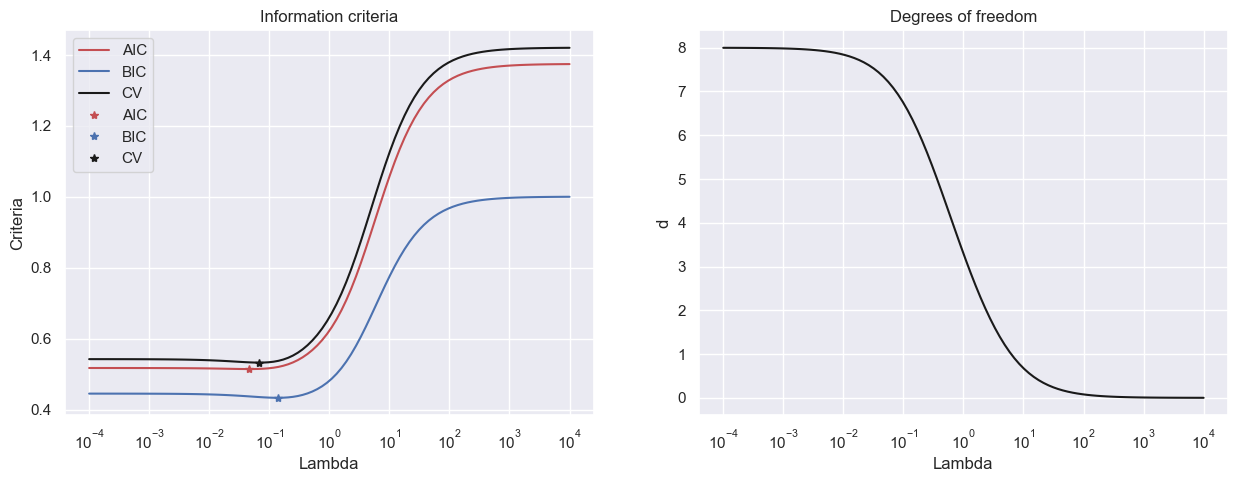

In [ ]:
# plot different methods Information criteria: AIC BIC CV
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].set_title("Information criteria")
_ = axs[0].semilogx(lambdas, AIC, "-r", label="AIC")
axs[0].semilogx(lambdas, BIC / 300, "-b", label="BIC")
axs[0].semilogx(lambdas, mean_MSE, "-k", label="CV")
axs[0].semilogx(lambdas[jAIC], np.min(AIC), "*r", label="AIC")
axs[0].semilogx(lambdas[jBIC], np.min(BIC) / 300, "*b", label="BIC")
axs[0].semilogx(lambdas[np.argmin(mean_MSE)], np.min(mean_MSE), "*k", label="CV")
axs[0].legend()
axs[0].set_xlabel("Lambda")
axs[0].set_ylabel("Criteria")

# plot the degree of freedom
axs[1].semilogx(lambdas, D, "-k")
axs[1].set_title("Degrees of freedom")
axs[1].set_xlabel("Lambda")
axs[1].set_ylabel("d")

> (e) Use the bootstrap to estimate the variance of the parameters of the solution $(β)$ for each value of lambda in exercise 1a. Plot the variance estimates as a function of lambda. What do you notice? 

Some betas have higher variance but all of them are pretty low. Suggests that the model is robust to variation in the training data.

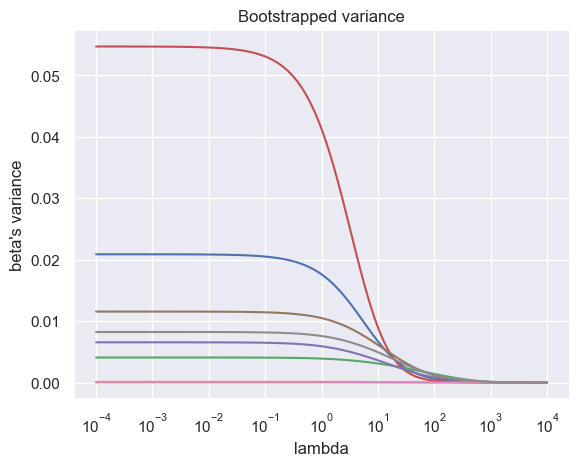

In [ ]:
NBoot = 100
Beta = np.zeros((p, len(lambdas), NBoot))

# Run bootstrap on ridge for the same range of lambdas as before
# similarly as with cross validation you run the bootstrap x times and each time you sample with replacement
# ridge is then run on that sample for each lambda value
for i in range(NBoot):
    I = np.random.randint(0, n, n)
    XBoot = X[I, :]
    yBoot = y[I]
    for j in range(100):
        Beta[:, j, i] = ridgeMulti(XBoot, lambdas[j], p, yBoot)

stdBeta = np.var(Beta, axis=2)
# Plot the varriance of the betas for each lambda value
plt.figure()
for i in range(8):
    plt.semilogx(lambdas, stdBeta[i, :])
plt.title("Bootstrapped variance")
plt.ylabel("beta's variance")
plt.xlabel("lambda")
plt.show()